# Enhancing Customer Experience and Boosting Sales in Online Retail

**Description:**

Imagine you’re part of a dynamic online retail company aiming to elevate customer experience and maximize sales. In this hackathon, participants will dive into a comprehensive Online Retail dataset, encompassing customer transactions, product details, and user behavior. The goal is to leverage data analysis techniques to gain valuable insights and propose strategies for enhancing customer satisfaction, optimizing the sales process, and maximizing Customer Lifetime Value (CLV).

There are several columns in the dataset, namely :

- Invoice : A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter ‘c’, it indicates a cancellation.
- StockCode : Product code. A 5-digit integral number uniquely assigned to each distinct product.
- Description : Product name.
- Quantity : The quantities of each product (item) per transaction.
- InvoiceDate : The day and time when a transaction was generated.
- UnitPrice : Product price per unit in sterling.
- CustomerID : A 5-digit integral number uniquely assigned to each customer.
- Country : The name of the country where a customer resides.

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [73]:
retail_data = pd.read_excel(r'/content/Online Retail.xlsx')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Basic exploration and data preprocessing

In [74]:
# check the shape
retail_data.shape

(541909, 8)

In [75]:
# check columns types
retail_data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [76]:
retail_data.duplicated().sum()

5268

In [77]:
retail_data = retail_data.drop_duplicates()

In [78]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


In [79]:
retail_data.CustomerID.isnull().sum()

135037

In [80]:
# Drop rows with missing customers IDs
retail_data = retail_data.dropna(subset=['CustomerID'])
retail_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [81]:
# Basic statistic
retail_data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


From descriptive statistics of quantitative variables (Quantity and UnitPrice), we could see that there are negative values in these variables, which are not possible values for price and quantity.

In [82]:
# handle negative value (cancel items)
cancelled = retail_data[retail_data['InvoiceNo'].astype(str).str.contains('C')]
cancelled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [144]:
print(f'Number of cancelled orders {len(cancelled)}')
print("Percentage of cancelled transactions:" , round(len(cancelled)/len(retail_data)*100, 2),"%")
print("Lost Revenue of cancelled transactions: ", round(sum(cancelled.Quantity * cancelled.UnitPrice)))
print("Percentage Lost Revenue of cancelled transactions:" , round((sum(cancelled.Quantity * cancelled.UnitPrice)/sum(retail_data.Quantity * retail_data.UnitPrice)),2),"%")

Number of cancelled orders 8872
Percentage of cancelled transactions: 2.21 %
Lost Revenue of cancelled transactions:  -608689
Percentage Lost Revenue of cancelled transactions: -0.07 %


In [84]:
# Stay only positive values
OR_data = retail_data[retail_data['Quantity'] >= 0]
OR_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [85]:
OR_data.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [86]:
OR_data.shape

(392732, 8)

In [87]:
# making new feature "Total Price"
OR_data['Total_price'] = OR_data['Quantity'] * OR_data['UnitPrice']

<ipython-input-87-1846447576b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_data['Total_price'] = OR_data['Quantity'] * OR_data['UnitPrice']


### Description

In [88]:
# It should be taken into accoun that the same description could be written in different cases, let's convert all description into lowercase.
OR_data['Description'] = OR_data['Description'].str.lower()

#Removing punctuations for the description
OR_data['Description'] = OR_data['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True)

<ipython-input-88-949b52d7b12f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_data['Description'] = OR_data['Description'].str.lower()
<ipython-input-88-949b52d7b12f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_data['Description'] = OR_data['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True)


In [89]:
OR_data['Description'].nunique()

3867

In [145]:
OR_data['StockCode'].nunique()

3665

We have 3867 items of goods in our Online Retail Store, and only 3665 unique stock codes. That could mean that there are more than one descriptions for 1 item.

In [151]:
code_descrip = OR_data.groupby('StockCode').agg({'Description':'nunique'})
code_descrip[code_descrip['Description']>1]

,Description
StockCode,
20622,2
20725,2
20914,2
21175,2
21232,2
...,...
85184C,2
85185B,2
90014A,2


There are 203 StockCode with few discriptions. So it's better to fix this problem for analisys in the future.

### Dates

In [90]:
!pip install datetime

In [91]:
import datetime as dt
from datetime import datetime

In [92]:
# Adding features as year, month, month_year, day of week, hour
OR_data['Year'] = OR_data['InvoiceDate'].dt.year
OR_data['Month'] = OR_data['InvoiceDate'].dt.month_name()
OR_data['WeekDay'] = OR_data['InvoiceDate'].dt.day_name()
OR_data['Hour'] = OR_data['InvoiceDate'].dt.hour

<ipython-input-92-5748528f7bf8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_data['Year'] = OR_data['InvoiceDate'].dt.year
<ipython-input-92-5748528f7bf8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OR_data['Month'] = OR_data['InvoiceDate'].dt.month_name()
<ipython-input-92-5748528f7bf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [93]:
OR_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,Year,Month,WeekDay,Hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,December,Wednesday,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,December,Wednesday,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8


## Exploratery data analysis

### The most popular product

In [94]:
top_product = OR_data.groupby('Description', as_index=False).agg({'Quantity':'sum'}).sort_values(by='Quantity', ascending = False).head(10)

In [95]:
top_product

,Description,Quantity
2314,paper craft little birdie,80995
1988,medium ceramic top storage jar,77916
3778,world war 2 gliders asstd designs,54319
1758,jumbo bag red retrospot,46078
3690,white hanging heart tlight holder,36706
216,assorted colour bird ornament,35263
2264,pack of 72 retrospot cake cases,33670
2595,popcorn holder,30919
2651,rabbit night light,27153
2043,mini paint set vintage,26076


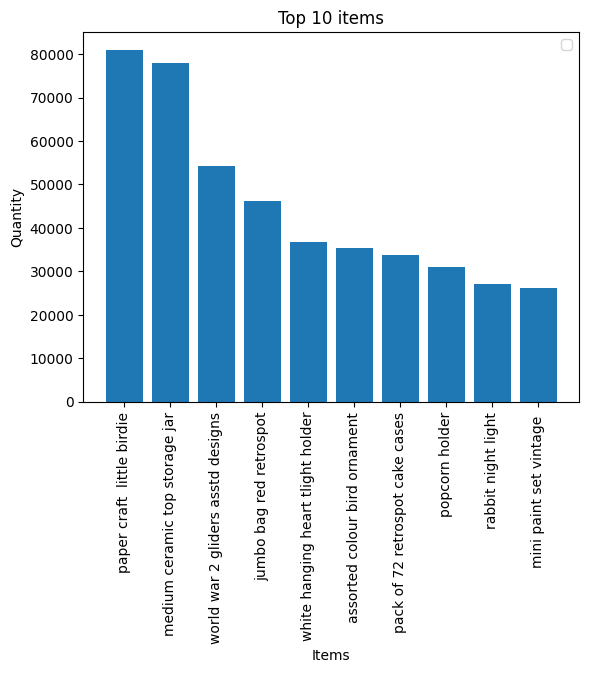

In [96]:
plt.bar(top_product.Description, top_product.Quantity)
plt.xlabel('Items')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.title('Top 10 items')
plt.legend()
plt.show()

 It can be seen that the most sold product is PAPER CRAFT LITTLE BIRDIE, namely 80995 products.

### Top Products by Revenue

In [97]:
top_revenue = OR_data.groupby('Description', as_index=False).agg({'Total_price':'sum'}).sort_values(by='Total_price', ascending = False).head(10)
top_revenue

,Description,Total_price
2314,paper craft little birdie,168469.60
2762,regency cakestand 3 tier,142264.75
3690,white hanging heart tlight holder,100392.10
1758,jumbo bag red retrospot,85040.54
1988,medium ceramic top storage jar,81416.73
2606,postage,77803.96
2340,party bunting,68785.23
216,assorted colour bird ornament,56413.03
1978,manual,53419.93
2651,rabbit night light,51251.24


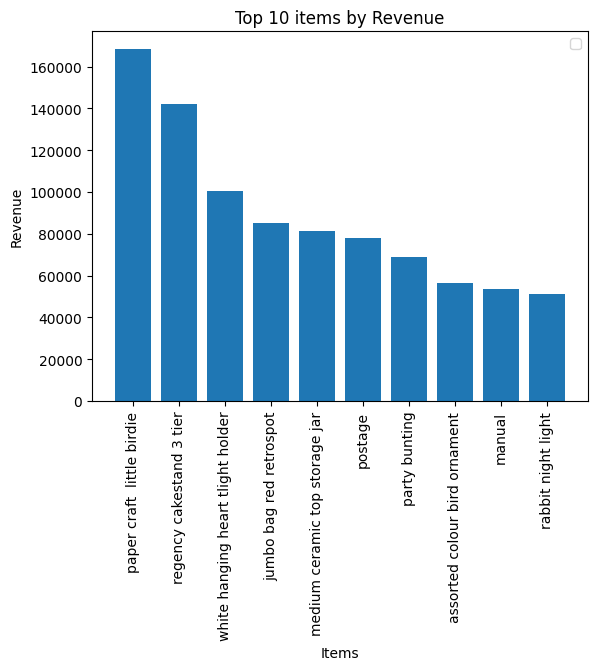

In [98]:
plt.bar(top_revenue.Description, top_revenue.Total_price)
plt.xlabel('Items')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
plt.title('Top 10 items by Revenue')
plt.legend()
plt.show()

The most revenue good is also "Paper Craft Little Birdie".

In [99]:
df = top_product.merge(top_revenue, how = 'outer', on = 'Description')
df

,Description,Quantity,Total_price
0,paper craft little birdie,80995.0,168469.60
1,medium ceramic top storage jar,77916.0,81416.73
2,world war 2 gliders asstd designs,54319.0,NaN
3,jumbo bag red retrospot,46078.0,85040.54
4,white hanging heart tlight holder,36706.0,100392.10
5,assorted colour bird ornament,35263.0,56413.03
6,pack of 72 retrospot cake cases,33670.0,NaN
7,popcorn holder,30919.0,NaN
8,rabbit night light,27153.0,51251.24
9,mini paint set vintage,26076.0,NaN


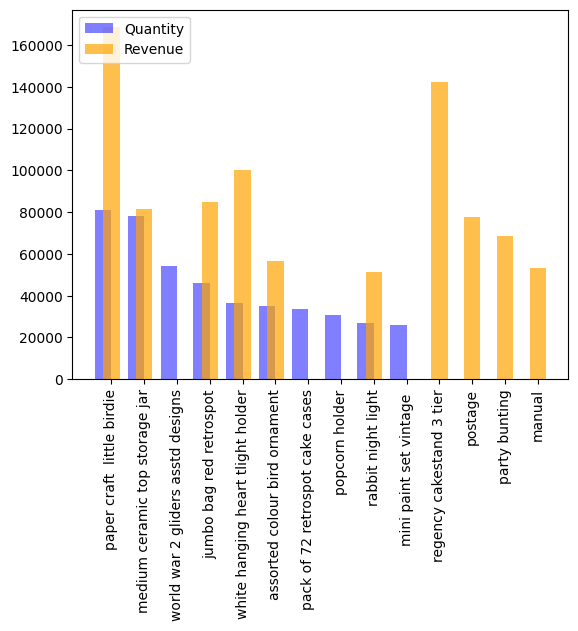

In [100]:
fig, ax = plt.subplots()
bar_width = 0.5

ax.bar(np.arange(len(df.Description)), df.Quantity, label='Quantity', color='blue', alpha=0.5, width=bar_width)
ax.bar(np.arange(len(df.Description)) + bar_width/2, df.Total_price, label='Revenue', color='orange', alpha=0.7, width=bar_width)

# Подписи оси X
ax.set_xticks(np.arange(len(df.Description)) + bar_width / 2)
ax.set_xticklabels(df.Description, rotation=90)

# Добавление легенды
ax.legend()

# Отображение графика
plt.show()



As we can see "Paper Craft Little birdie" is both the best-selling and highest revenue earner. While "Regency Cakestand 3 tier" or "Postage" generate good revenue, but are not in the top 10 in terms of sales volume. And some goods from TOP Sales are not in TOP revenue.

Let's check the most expensive items.

### Top-10 Most Expensive Items

In [101]:
expens_goods = OR_data.groupby('Description', as_index = False).agg({'UnitPrice':'mean'}).sort_values(by = 'UnitPrice', ascending = False).head(10)
expens_goods

,Description,UnitPrice
1033,dotcom postage,744.147500
2390,picnic basket wicker 60 pieces,649.500000
1978,manual,174.650211
2880,rustic seventeen drawer sideboard,158.076923
2764,regency mirror with shutters,156.428571
3547,vintage blue kitchen cabinet,146.750000
3596,vintage red kitchen cabinet,143.421053
687,chest natural wood 20 drawers,118.076923
1927,love seat antique white metal,114.024390
3592,vintage post office cabinet,66.360000


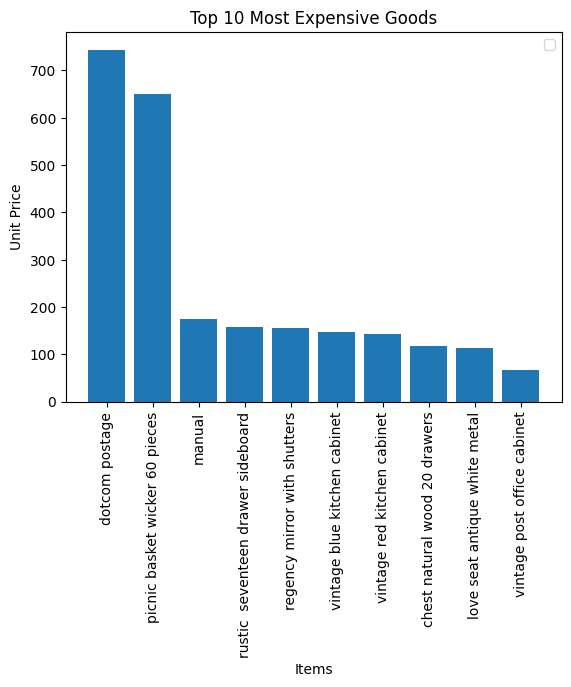

In [102]:
plt.bar(expens_goods.Description, expens_goods.UnitPrice)
plt.xlabel('Items')
plt.xticks(rotation=90)
plt.ylabel('Unit Price')
plt.title('Top 10 Most Expensive Goods')
plt.legend()
plt.show()

We have 2 products with the highest prices that did not make it into the previous ranking. It is worth paying attention to these products. Perhaps they have little advertising or their price is too high.

### Transactions by countries

In [103]:
customer_country = OR_data.groupby(['Country']).agg({'CustomerID':'count','Total_price':'sum'}).reset_index().sort_values('CustomerID', ascending=False)
print(f'Transactions were made from {len(customer_country)} different countries')

Transactions were made from 37 different countries


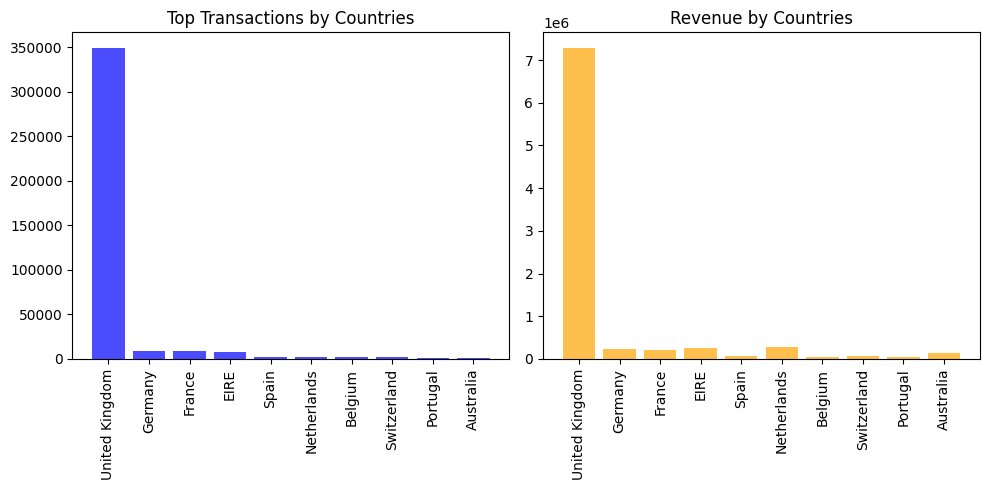

In [104]:
top_country = customer_country.head(10)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot order per day
axes[0].bar(top_country['Country'], top_country['CustomerID'], color='blue', alpha=0.7)
axes[0].set_title('Top Transactions by Countries')
axes[0].set_xticks(top_country['Country'])
axes[0].set_xticklabels(top_country['Country'], rotation=90)

# Plot revenue per Day
axes[1].bar(top_country['Country'], top_country['Total_price'], color='orange', alpha=0.7)
axes[1].set_title('Revenue by Countries')
axes[1].set_xticks(top_country['Country'])
axes[1].set_xticklabels(top_country['Country'], rotation=90)

plt.tight_layout()
plt.show()

The biggest number of orders are made in United Kingdom, which is expected, because the store is UK-based. The most unique customers are from United Kingdom, for this reason it is better to concetrate on UK for customer segmentation.

## Time-Series Analysis for Seasonal Trends:

### How many orders per month?

In [105]:
sale_per_month = OR_data.groupby('Month', as_index=False).agg({'Description':'count', 'Total_price':'sum'})
sale_per_month

,Month,Description,Total_price
0,April,22435,468374.331
1,August,26796,644051.040
2,December,42699,1087613.170
3,February,19707,446084.920
4,January,20991,568101.310
5,July,26582,598962.901
6,June,26926,660046.050
7,March,26872,594081.760
8,May,28075,677355.150
9,November,63182,1156205.610


In [106]:
# Getting right order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sale_per_month['Month'] = pd.Categorical(sale_per_month['Month'], categories=month_order, ordered=True)

# Sort DataFrame by Months
sale_per_month = sale_per_month.sort_values('Month')
sale_per_month

,Month,Description,Total_price
4,January,20991,568101.310
3,February,19707,446084.920
7,March,26872,594081.760
0,April,22435,468374.331
8,May,28075,677355.150
6,June,26926,660046.050
5,July,26582,598962.901
1,August,26796,644051.040
11,September,39671,950690.202
10,October,48796,1035642.450


<ipython-input-107-6e11b1fc508d>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(sale_per_month['Month'], rotation=45)
<ipython-input-107-6e11b1fc508d>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(sale_per_month['Month'], rotation=45)


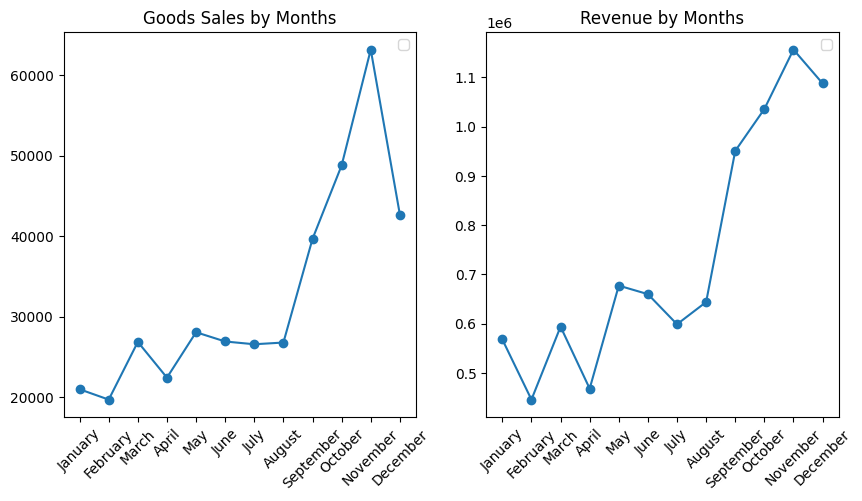

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# monthly sales
axes[0].plot(sale_per_month['Month'], sale_per_month['Description'], marker='o')
axes[0].set_title('Goods Sales by Months')
axes[0].set_xticklabels(sale_per_month['Month'], rotation=45)
axes[0].legend()

# monthly revenue
axes[1].plot(sale_per_month['Month'], sale_per_month['Total_price'], marker='o')
axes[1].set_title('Revenue by Months')
axes[1].set_xticklabels(sale_per_month['Month'], rotation=45)
axes[1].legend()

There are more purchasing made at the end of the year. The highest number of transactions were made during November. And the highest sales are also during the November. Probably reason could be the fact, that people tend to prepare for Christmas during November. Other than November number of byuings during the year is quite similar.

### How many orders per day?

In [108]:
# Group orders by days of week
sale_per_day = OR_data.groupby('WeekDay', as_index=False).agg({'Description':'count', 'Total_price':'sum'})

# Getting right order of months
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sale_per_day['WeekDay'] = pd.Categorical(sale_per_day['WeekDay'], categories=weekday_order, ordered=True)

# Sorting DataFrame by the order of weekdays
sale_per_day = sale_per_day.sort_values('WeekDay')
sale_per_day

,WeekDay,Description,Total_price
1,Monday,64237,1363604.401
4,Tuesday,65747,1697733.801
5,Wednesday,68043,1584283.830
3,Thursday,79260,1973015.730
0,Friday,54231,1483080.811
2,Sunday,61214,785490.321


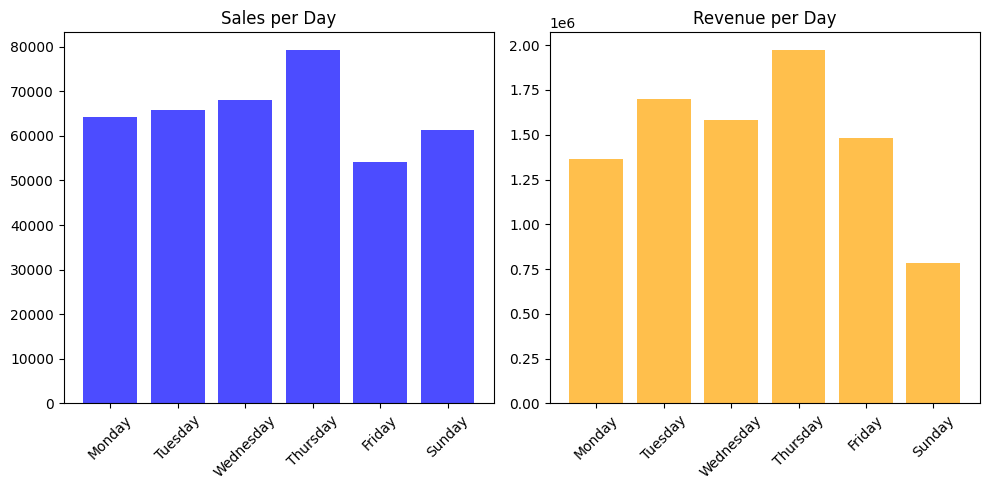

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot order per day
axes[0].bar(sale_per_day['WeekDay'], sale_per_day['Description'], color='blue', alpha=0.7)
axes[0].set_title('Sales per Day')
axes[0].set_xticks(sale_per_day['WeekDay'])
axes[0].set_xticklabels(sale_per_day['WeekDay'], rotation=45)

# Plot revenue per Day
axes[1].bar(sale_per_day['WeekDay'], sale_per_day['Total_price'], color='orange', alpha=0.7)
axes[1].set_title('Revenue per Day')
axes[1].set_xticks(sale_per_day['WeekDay'])
axes[1].set_xticklabels(sale_per_day['WeekDay'], rotation=45)

plt.tight_layout()
plt.show()

Interesting fact is that there were not any transaction on Saturday during the whole period. One of the explanations could be some filter during the data collection process. Number of buyings are not significantly differ according to the day of the week.

On Sunday people prefer to order a lot of chip purchases.

### How many orders per hour?

In [110]:
# Group orders by hours
sale_per_hour = OR_data.groupby('Hour', as_index=False).agg({'Description':'count', 'Total_price':'sum'})
sale_per_hour

,Hour,Description,Total_price
0,6,1,4.250
1,7,379,31059.210
2,8,8688,281997.790
3,9,21928,842392.341
4,10,37775,1259267.591
5,11,48373,1101177.600
6,12,70942,1373695.390
7,13,63024,1168724.200
8,14,53260,991992.821
9,15,44793,963559.680


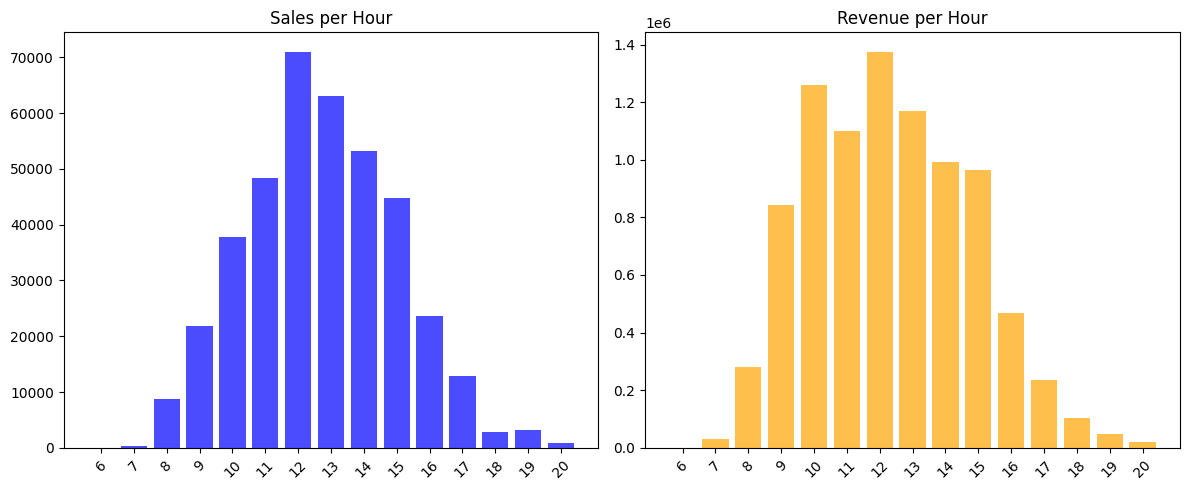

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot order per day
axes[0].bar(sale_per_hour['Hour'], sale_per_hour['Description'], color='blue', alpha=0.7)
axes[0].set_title('Sales per Hour')
axes[0].set_xticks(sale_per_hour['Hour'])
axes[0].set_xticklabels(sale_per_hour['Hour'], rotation=45)

# Plot revenue per Day
axes[1].bar(sale_per_hour['Hour'], sale_per_hour['Total_price'], color='orange', alpha=0.7)
axes[1].set_title('Revenue per Hour')
axes[1].set_xticks(sale_per_hour['Hour'])
axes[1].set_xticklabels(sale_per_hour['Hour'], rotation=45)

plt.tight_layout()
plt.show()

The most number of transactions is done between 11.00 and 15.00, people tend to make there purchase during the lunch time. There aren't any transactions after 20.00 till 6.00.


## Metrics Analysis:

### ARPPU (Avarage Revenue Per Paying User)

In [112]:
from operator import or_
# Assuming 'CustomerID' is the column representing customer identifiers
paying_users = OR_data['CustomerID'].unique()

# Calculate ARPPU
total_revenue = OR_data['Total_price'].sum().mean()
arppu = total_revenue/len(paying_users)
print(f'ARPPU: {arppu}')

ARPPU: 2048.2159239456105


The ARPPU of 2048.22 indicates a healthy average spending from each paying user, suggesting that your business is effectively monetizing its user base.

### LTV (Lifetime Value)

In [113]:
# Calculate average purchase value
average_purchase_value = OR_data[OR_data['CustomerID'].isin(paying_users)]['Total_price'].mean()

# Calculate purchase frequency
purchase_frequency = len(OR_data[OR_data['CustomerID'].isin(paying_users)]) / len(paying_users)

In [114]:
# Set average customer lifespan
first_order_date = OR_data.groupby('CustomerID',as_index=False).agg({'InvoiceDate':'min'}).rename(columns={'Invoice_date':'First_date'})
last_order_date = OR_data.groupby('CustomerID',as_index=False).agg({'InvoiceDate':'max'}).rename(columns={'Invoice_date':'Last_date'})
cls = first_order_date.merge(last_order_date, how = 'inner', on = 'CustomerID')
cls

,CustomerID,InvoiceDate_x,InvoiceDate_y
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00
...,...,...,...
4334,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00
4335,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00
4336,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00
4337,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00


In [115]:
cls.rename(columns = {'InvoiceDate_x':'First_Date', 'InvoiceDate_y':'Last_Date'}, inplace = True)
cls

,CustomerID,First_Date,Last_Date
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00
...,...,...,...
4334,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00
4335,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00
4336,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00
4337,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00


In [116]:
cls['CLS'] = cls['Last_Date'] - cls['First_Date']
cls['CLS'] = cls['CLS'].abs()
cls

,CustomerID,First_Date,Last_Date,CLS
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0 days 00:00:00
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,365 days 00:55:00
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282 days 18:04:00
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days 00:00:00
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0 days 00:00:00
...,...,...,...,...
4334,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,0 days 00:00:00
4335,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,0 days 00:00:00
4336,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00,118 days 22:08:00
4337,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00,333 days 21:48:00


In [117]:
# Average customer lifespan
average_lifespan = (cls['CLS'].mean().days)/365

# Calculate LTV
ltv = average_purchase_value * purchase_frequency * average_lifespan
print(f'LTV: {ltv}')

LTV: 729.5015619532311


The LTV of 729.50 suggests that, on average, a customer's value extends beyond a single transaction. This is important for understanding the long-term revenue potential and justifying customer acquisition costs.

### Churn Rate

In [118]:
# Calculate Churn Rate
all_customers = len(OR_data['CustomerID'].unique())
one_order_customers = len(cls.query('CLS == "0 days"').groupby('CustomerID'))
churn_rate =  one_order_customers/ all_customers
print(f'Churn Rate: {churn_rate * 100}%')

Churn Rate: 34.47799032035031%


The Churn Rate of 34.48% may indicate a relatively high rate of customer attrition. It's essential to address churn to retain customers, as acquiring new customers is often more costly than retaining existing ones.

## Customer Segmentation:

RFM analysis is a way to use data based on existing customer behavior to predict how a new customer is likely to act in the future.

RFM analysis ranks each customer on the following factors:

* Recency. How recent was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours.
* Frequency. How often did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers.
* Monetary. How much money did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.

In [119]:
# Select only UK customers:
df_uk = OR_data[OR_data['Country'] == "United Kingdom"]
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,Year,Month,WeekDay,Hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,December,Wednesday,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,December,Wednesday,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,December,Wednesday,8


In [120]:
print(df_uk['InvoiceDate'].min())
print(df_uk['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:49:00


In the dataset, the last order was placed on 9 of December 2011, I used next day as the date for the NOW function to calculate the statute of limitations.

In [121]:
now = dt.datetime(2011,12,10)
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

<ipython-input-121-1c6e4eb547a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])


In [122]:
# We only need the following columns from the dataset to RFM-analyze.
temp=['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Total_price']
RFM_data=df_uk[temp]
RFM_data.shape

(349227, 4)

In [123]:
# RFM Table
RFM_table=RFM_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days, # Recency
                                                'InvoiceNo': lambda x: len(x.unique()), # Frequency
                                                'Total_price': lambda x: x.sum()})    # Monetary

RFM_table['InvoiceDate'] = RFM_table['InvoiceDate'].astype(int)

RFM_table.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'Total_price': 'monetary_value'}, inplace=True)

In [124]:
RFM_table.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,4196.01
12748.0,0,210,33053.19
12749.0,3,5,4090.88
12820.0,3,4,942.34


In [125]:
# Define quantiles for rfm score
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,17.0,1.0,298.11
0.50,50.0,2.0,644.30
0.75,142.0,5.0,1570.81


In [126]:
# Converting quantiles to a dictionary, easier to use.
quantiles = quantiles.to_dict()

In [127]:
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [128]:
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))

In [129]:
RFM_Segment.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12747.0,2,11,4196.01,4,4,4
12748.0,0,210,33053.19,4,4,4
12749.0,3,5,4090.88,4,3,4
12820.0,3,4,942.34,4,3,3


### Perform K-Means Clustering

K-Means clustering is sensitive to the scale of features. Because the R, F, and M values are all on the same scale, we can proceed to perform clustering without further scaling the features.

In [130]:
# Extract RFM scores for K-means clustering
X = RFM_Segment[['R_Quartile', 'F_Quartile', 'M_Quartile']]

Now, we need to find the optimal number of clusters. For this let’s run the K-Means algorithm for a range of K values and use the elbow method to pick the optimal K:

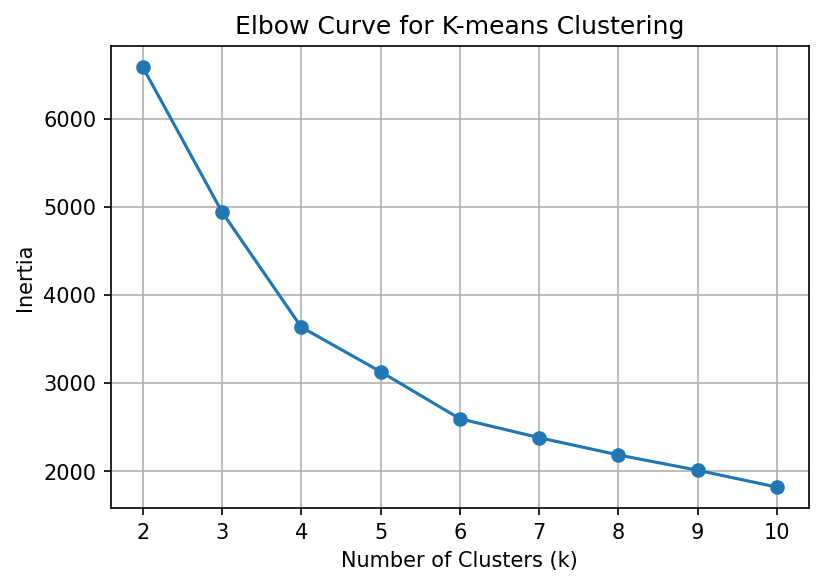

In [131]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

We see that the curve elbows out at 4 clusters. So let’s divide the customer base into four segments.

In [132]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
RFM_Segment['Cluster'] = best_kmeans.fit_predict(X)

We need to characterize them based on the RFM scores.

In [133]:
# Group by cluster and calculate mean values
cluster_summary = RFM_Segment.groupby('Cluster').agg({
    'R_Quartile': 'mean',
    'F_Quartile': 'mean',
    'M_Quartile': 'mean'
}).reset_index()

cluster_summary

,Cluster,R_Quartile,F_Quartile,M_Quartile
0,0,2.142272,2.849539,3.065507
1,1,1.379364,1.237393,1.517455
2,2,3.432099,1.587963,1.662037
3,3,3.718967,3.672294,3.746773


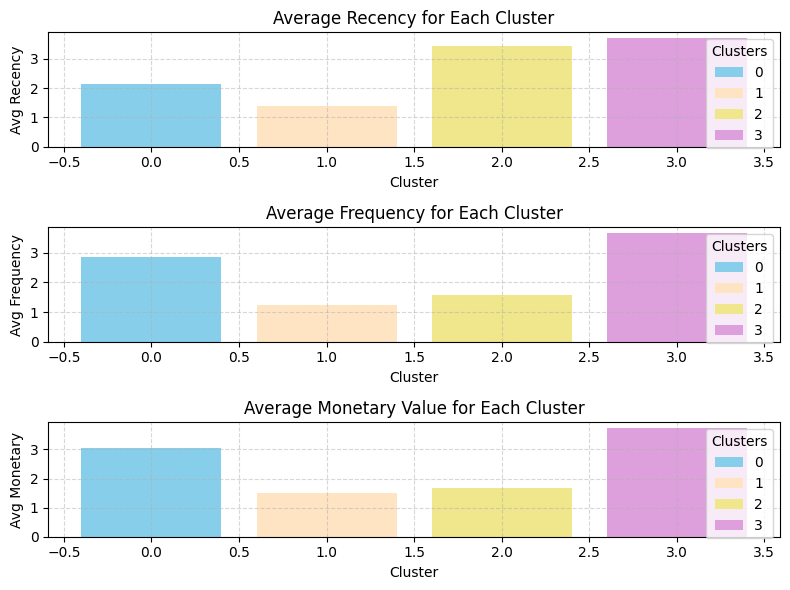

In [134]:
colors = ['skyblue', 'bisque', 'khaki','plum']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(8, 6))

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Quartile'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Quartile'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Quartile'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

The customers in each of the segments can be characterized based on the recency, frequency, and monetary values:

 **Cluster 0**: Of all the four clusters, this cluster has the highest recency, frequency, and monetary values. Let’s call the customers in this cluster **'Champions'**.

**Cluster 1**: This cluster is characterized by moderate recency, frequency, and monetary values. These customers still spend more and purchase more frequently than clusters 2 and 3. Let’s call them **'Loyal Customers'**.

**Cluster 2**: Customers in this cluster tend to spend less. They don’t buy often, and haven’t made a purchase recently either. These are **'Almost Lost Customers'**.

**Cluster 3**: This cluster is characterized by high recency and relatively lower frequency and moderate monetary values. So these are **'New Customers'** who can potentially become long-term customers.

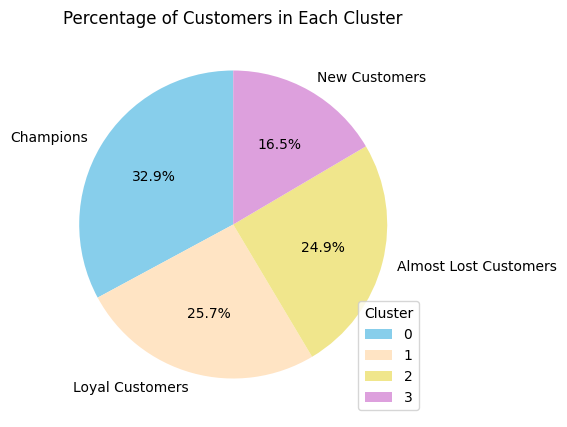

In [135]:
# Visualize the distribution of the different clusters using a pie chart:
cluster_counts = RFM_Segment['Cluster'].value_counts()

colors = ['skyblue', 'bisque', 'khaki','plum']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions','Loyal Customers','Almost Lost Customers','New Customers']

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='lower right')

plt.show()

## Product Recommendation System:

Make a matrix where rows represent users and columns represent items (products).

In [152]:
# Select relevant columns
user_item_matrix = OR_data.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
user_item_matrix


StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,0.00
12347.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,0.00
12348.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,2.25
12349.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,1.00
12350.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,0.00
18281.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,0.00
18282.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0,0.00


In [137]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate user similarity matrix using cosine similarity
user_similarity = cosine_similarity(user_item_matrix)

# Create a DataFrame with user similarity scores
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function to get product recommendations for a given user
def get_recommendations(user_id, user_item_matrix, user_similarity_df, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]

    recommendations = []

    for similar_user in similar_users:
        similar_user_ratings = user_item_matrix.loc[similar_user]
        unrated_products = similar_user_ratings[similar_user_ratings == 0].index
        recommended_products = unrated_products[:top_n]

        recommendations.extend(recommended_products)

    return list(set(recommendations))

# Example: Get recommendations for a specific user
user_id = 17850.0
recommendations = get_recommendations(user_id, user_item_matrix, user_similarity_df)
print("Recommendations for user {}: {}".format(user_id, recommendations))

Recommendations for user 17850.0: [10080, 16033, 10120, 16043, 10125, 16046, 10002, 10133, 15030, 10135, 11001, 15034]


This function takes a user ID, user-item matrix, user similarity DataFrame, and an optional parameter top_n. It returns a list of recommended products for the given user.
The code then iterates through the similar users, finds unrated products by those users, and recommends the top top_n unrated products. The recommendations are collected in the recommendations list.

## Conclusions and Recomendations:

1. **Data Collection.**
There are problems in data collections and data integration processes which should be solved, for more effective data analysis and more clear sollutions:

- Missing customer ID - this column could be made not nullable, in case for treatment occurences of missing IDs.
- Not valid Stock Codes (contains different letters/some words) - some checking constraints for stock codes.
- Duplicate transasctions - probably data were collected from multiple sources, which caused some duplictities.

Solving of problems related to data quality could significantly improve the results of algorithms.

2. **Cancelled Orders.** There are 8872 (2.21%) cancelled orders, indicates a relatively low cancellation rate. However, it's essential to monitor and understand the reasons behind canceled transactions to mitigate potential negative impacts on customer satisfaction and revenue.

3. **Sales.**
- "Paper Craft Little Birdie" emerges as both the best-selling and highest revenue earner, indicating its popularity among customers. Leverage the popularity of "Paper Craft Little Birdie" by featuring it in promotional campaigns. Consider bundling it with other items or offering discounts to further boost sales.

- "Regency Cakestand 3 tier" and "Postage" generate substantial revenue but do not rank in the top 10 in terms of sales volume. This suggests that these items may have a higher price point or contribute more to the overall revenue despite fewer units sold. For high-revenue these items consider optimizing pricing strategies to maintain profitability while potentially increasing sales volume.

- A separate analysis of the top 10 most expensive products reveals two items with the highest prices that did not make it into the top sales and revenue rankings. This indicates the presence of high-value items that contribute significantly to the revenue but may not be as frequently purchased. Explore opportunities to introduce more high-value items similar to the top 10 most expensive products. This can contribute to overall revenue and attract customers looking for premium products.

4. **Geographic Distribution.** The majority of transactions occur in the United Kingdom, which aligns with expectations as the store is UK-based. Evaluate the potential for expanding the customer base beyond the United Kingdom. Targeted marketing campaigns or partnerships may help attract international customers.

5. **Seasonal Trends.** Purchases tend to increase towards the end of the year, with November having the highest number of transactions. This may be influenced by holiday shopping trends. Capitalize on the seasonal trends observed, especially during November. Plan targeted promotions, discounts, or exclusive offers to drive sales during peak shopping periods.

5. **Date-Time Analysis.**
- No transactions were recorded on Saturdays throughout the period. Purchasing behavior shows no significant differences based on the day of the week. Recognizing the preference for multiple but lower-value purchases on Sundays, tailor promotions or special offers that align with these shopping behaviors.
- The highest number of transactions occurs between 11:00 and 15:00, indicating that people tend to make purchases during the lunchtime period. There are no transactions recorded after 20:00 until 6:00. Since transactions drop off after 20:00, consider optimizing operational hours, customer support, or targeted promotions during peak buying times between 11:00 and 15:00.

6. **ARPPU, LTV, and Churn Rate.**
Average Revenue Per Paying User (ARPPU) is calculated as 2048.22, Lifetime Value (LTV) is 729.50, and Churn Rate is 34.48%. These metrics provide insights into customer spending and retention. Overall, while the ARPPU and LTV metrics are positive, addressing and reducing the churn rate should be a priority to ensure sustained growth and maximize the lifetime value of customers. Given the Churn Rate of 34.48%, focus on customer retention strategies. Implement loyalty programs, personalized offers, or exclusive access to encourage repeat purchases.

7. **RFM Analysis.** Using RFM segmentation, customers are categorized into four cohorts: Champions (32.9%), Loyal (25.7%), Almost Lost (24.9%), and Recent Customers (16.5%). This segmentation allows for targeted marketing and engagement strategies based on customer behavior. Tailor marketing campaigns for each RFM segment. For example, engage Champions with exclusive offers, nurture Loyal customers with loyalty rewards, re-engage Almost Lost customers with targeted promotions, and welcome Recent Customers with introductory offers.

In summary, the analysis provides a comprehensive view of product performance, customer behavior, and key metrics. These insights can guide strategic decisions, marketing efforts, and customer engagement initiatives for the business. Company should regularly monitor sales, customer behavior, and key metrics. Use this information to adapt strategies, identify new trends, and respond to changing customer preferences.